# Conda Environment Setup

All environment settings are written in ```environment.yml```. You can create the environment by running the following command in the terminal:

```shell
conda env create -f environment.yml
```

# Get Started

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Plot the data

Plot a line graph showing the sequence in amp_data, and a histogram of the amplitudes in this sequence. 

Include the code for your plots, with one to three sentences about anything you notice that might be important for modelling these data.

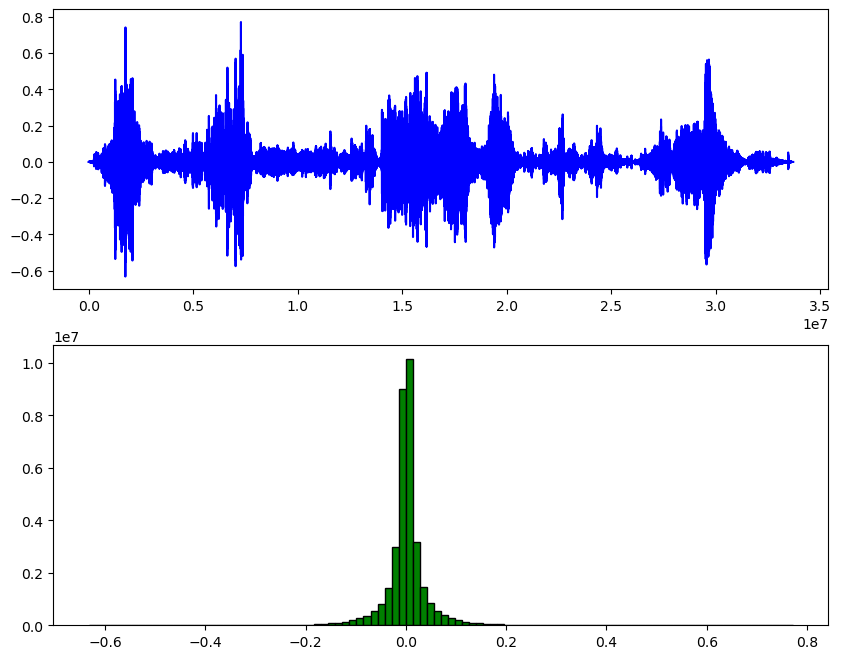

In [3]:
amp_data = np.load('amp_data.npz')['amp_data']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Line graph of the sequence
ax1.plot(amp_data, color='blue')

# Histogram of the amplitudes
ax2.hist(amp_data, bins=100, color='green', edgecolor='black')

plt.show()

## Create dataset

Include your code for creating the six arrays above from the original amp_data array. Your answers to future questions should assume these arrays exist, rather than relisting the code from this part.

In [4]:
# Define the number of columns for reshaping (R*21 matrix)
R = 21

# Calculate how many elements we can keep for reshaping
num_rows = len(amp_data) // R

# Truncate the amp_data to fit perfectly into a matrix of shape (num_rows, R)
amp_data_truncated = amp_data[:num_rows * R]

# Reshape the data into (num_rows, 21) matrix
amp_matrix = amp_data_truncated.reshape(num_rows, R)

# Shuffle the rows of the matrix
amp_matrix_shuffled = np.random.permutation(amp_matrix)

# Split the data into training (70%), validation (15%), and testing (15%)
train_size = int(0.7 * num_rows)
val_size = int(0.15 * num_rows)

# Training data
X_shuf_train = amp_matrix_shuffled[:train_size, :-1]
y_shuf_train = amp_matrix_shuffled[:train_size, -1]

# Validation data
X_shuf_val = amp_matrix_shuffled[train_size:(train_size + val_size), :-1]
y_shuf_val = amp_matrix_shuffled[train_size:(train_size + val_size), -1]

# Testing data
X_shuf_test = amp_matrix_shuffled[(train_size + val_size):, :-1]
y_shuf_test = amp_matrix_shuffled[(train_size + val_size):, -1]

# Saving the random seed for future reproducibility
random_seed = 42

# Displaying the shapes of the created datasets
(X_shuf_train.shape, y_shuf_train.shape, X_shuf_val.shape, y_shuf_val.shape, X_shuf_test.shape, y_shuf_test.shape)

((1123775, 20), (1123775,), (240809, 20), (240809,), (240810, 20), (240810,))

# Curve fitting on a snippet of audio

Given just one row of inputs, we could fit a curve of amplitude against time through the 20 points, and extrapolate it one step into the future. Plot the points in one row of your ```X_shuf_train``` data against the numbers $t = \frac{0}{20}, ..., \frac{19}{20}$, representing times. We can fit this sequence with various linear regression models, and extrapolate them to predict the 21st time step at time $\frac{20}{20} = 1$. Indicate the point you’re predicting from ```y_shuf_train``` on the plot at $t = 1$.

First fit and plot a straight line to the 20 training points. Then fit a quartic polynomial, by expanding each time $t$ to a feature vector $\phi(t) = [1, t, t^2, t^3, t^4]^T$ and fitting a linear model by least squares. Plot both fits between $t = 0$ and $t = 1$.


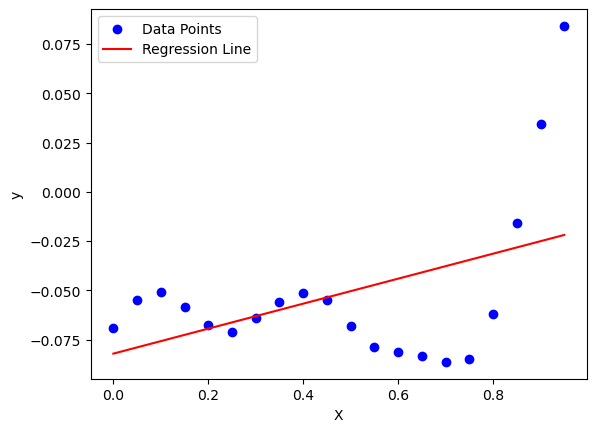

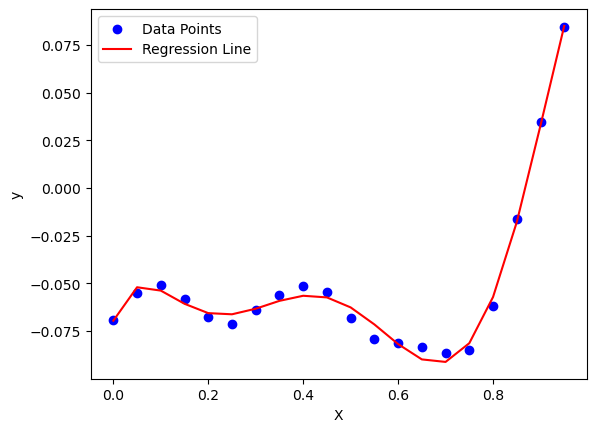

In [5]:
# y = wt + b
t_values = np.linspace(0, 19 / 20, 20)

# Fit a straight line (linear model)
row_index = 115
A_linear = np.vstack([t_values, np.ones(len(t_values))]).T
coeffs_linear = np.linalg.lstsq(A_linear, X_shuf_train[row_index], rcond=None)[0]
linear_fit = A_linear @ coeffs_linear


plt.scatter(t_values, X_shuf_train[row_index], color="blue", label="Data Points")
plt.plot(t_values, linear_fit, color="red", label="Regression Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

A_quartic = np.vstack([t_values**6, t_values**5, t_values**4, t_values**3, t_values**2, t_values, np.ones(len(t_values))]).T
coeffs_quartic = np.linalg.lstsq(A_quartic, X_shuf_train[row_index], rcond=None)[0]
quartic_fit = A_quartic @ coeffs_quartic


plt.scatter(t_values, X_shuf_train[row_index], color="blue", label="Data Points")
plt.plot(t_values, quartic_fit, color="red", label="Regression Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Provide code for a function Phi(C, K) that constructs a $C\times K$ design matrix $\Phi$ representing the $C$ most recent time steps before the time we wish to predict $(t=1)$. That is, the input times are $t^{(C)} = \frac{19}{20}, t^{(C-1)} = \frac{18}{20}, ...$.The row for time $t$ should have $K$ features $\phi(t) = [1, t, t^2, ..., t^{K-1}]^T$

In [16]:
def Phi(C, K):
    t_values = np.linspace(19 / 20, (20 - C) / 20, C)
    Phi = np.ones((C, K))
    for i in range(len(t_values)):
        for j in range(K):
            Phi[i][j] = t_values[i]**j
    return Phi

print(Phi(5, 4))

[[1.       0.95     0.9025   0.857375]
 [1.       0.9      0.81     0.729   ]
 [1.       0.85     0.7225   0.614125]
 [1.       0.8      0.64     0.512   ]
 [1.       0.75     0.5625   0.421875]]


Provide code for a function ```make_vv(C, K)``` that returns the vector $v$ that you derived in part a) for a model with $K$ features and a context of $C$ previous amplitudes, using the function from the previous part.

In [17]:
def make_vv(C, K):
    phi = Phi(C, K)
    phi_t_1 = np.ones((K, 1))
    vv = phi @ np.linalg.inv(phi.T @ phi) @ phi_t_1
    return vv
    
make_vv(5, 4)

array([[ 3.19999998],
       [-2.79999994],
       [-0.8       ],
       [ 2.19999995],
       [-0.79999997]])

Include a short demonstration that using two vectors from ```make_vv(C, K)```, for appropriate $C$ and $K$, you can make the same predictions at time $t=1$ as the linear and quartic curves you fitted in Q2.

In [18]:
def squared_error(vv, context_data, true_value):
    # Predict value at t=1
    predicted_value = vv.T @ context_data
    return np.sum((predicted_value - true_value)**2)

# Define ranges for C (context lengths) and K (basis functions)
C_values = range(2, 21)
K_values = range(2, 9)

best_C = None
best_K = None
min_error = float('inf')

# Loop over each combination of C and K
for C in C_values:
    for K in K_values:
        print(f"Evaluating C = {C}, K = {K}")
        vv = make_vv(C, K)

        total_squared_error = 0
        
        for i in range(len(X_shuf_train)):
            context_data = X_shuf_train[i][:C]
            true_value = y_shuf_train[i]
            
            total_squared_error += squared_error(vv, context_data, true_value)
        
        avg_squared_error = total_squared_error / len(X_shuf_train)
        if avg_squared_error < min_error:
            min_error = avg_squared_error
            best_C = C
            best_K = K

print(f"Best C: {best_C}, Best K: {best_K}, Minimum squared error: {min_error}")


Evaluating C = 2, K = 2
Evaluating C = 2, K = 3
Evaluating C = 2, K = 4
Evaluating C = 2, K = 5
Evaluating C = 2, K = 6
Evaluating C = 2, K = 7
Evaluating C = 2, K = 8
Evaluating C = 3, K = 2
Evaluating C = 3, K = 3
Evaluating C = 3, K = 4
Evaluating C = 3, K = 5
Evaluating C = 3, K = 6
Evaluating C = 3, K = 7
Evaluating C = 3, K = 8
Evaluating C = 4, K = 2
Evaluating C = 4, K = 3
Evaluating C = 4, K = 4
Evaluating C = 4, K = 5
Evaluating C = 4, K = 6
Evaluating C = 4, K = 7
Evaluating C = 4, K = 8
Evaluating C = 5, K = 2
Evaluating C = 5, K = 3
Evaluating C = 5, K = 4
Evaluating C = 5, K = 5
Evaluating C = 5, K = 6
Evaluating C = 5, K = 7
Evaluating C = 5, K = 8
Evaluating C = 6, K = 2
Evaluating C = 6, K = 3
Evaluating C = 6, K = 4
Evaluating C = 6, K = 5
Evaluating C = 6, K = 6
Evaluating C = 6, K = 7
Evaluating C = 6, K = 8
Evaluating C = 7, K = 2
Evaluating C = 7, K = 3
Evaluating C = 7, K = 4
Evaluating C = 7, K = 5
Evaluating C = 7, K = 6
Evaluating C = 7, K = 7
Evaluating C = 7

In [19]:
C = 3
K = 4
vv = make_vv(C, K)
total_squared_error = 0

name_sets = ["Training", "Validation", "Testing"]
x_sets = [X_shuf_train, X_shuf_val, X_shuf_test]
y_sets = [y_shuf_train, y_shuf_val, y_shuf_test]

for i in range(3):
    dataset = x_sets[i]
    label = y_sets[i]
    for j in range(len(dataset)):
        context_data = dataset[j][:C]
        true_value = label[j]
            
        total_squared_error += squared_error(vv, context_data, true_value)
        
    avg_squared_error = total_squared_error / len(dataset)
        
    print(f"{name_sets[i]} dataset, Average squared error: {avg_squared_error}")


Training dataset, Average squared error: 0.001750029478204501
Validation dataset, Average squared error: 0.009899918112671486
Testing dataset, Average squared error: 0.011645825850057502


# Fitting linear predictors across many snippets:
It’s possible we could do better by picking different basis functions. However, no matter which basis functions we pick, a linear model fitted by least squares will predict the next amplitude using a linear combination of the previous amplitudes.

Given a large dataset, we can try to fit a good linear combination directly, without needing to specify basis functions. Using standard linear least squares fitting code, we can find the vector $v$ that minimizes $$\sum_{n=1}(y^{(n)} - v^\top x^{(n)})^2$$
on the training set. Again, $y^{(n)}$ is the $n-$th amplitude to predict, based on a history of previous amplitudes in $x^{(n)}$.

We can choose to make the prediction based on a shorter history than all of the previous 20 amplitudes available. For $C=1, 2, ..., 20$, fit vectors $v^{(c)}$, each of length $C$, that can combine $C$ previous amplitudes to predict the next amplitude.

In [20]:
results = []
for C in range(1, 21):
    X_val_C = X_shuf_val[:, :C]
    
    v_C, residuals, rank, s = np.linalg.lstsq(X_val_C, y_shuf_val, rcond=None)
    
    # Calculate the predicted values using the fitted vector v^{(C)}
    y_pred = X_val_C @ v_C
    
    # Compute the mean squared error for this C
    mse_C = np.mean((y_pred - y_shuf_val)**2)
    
    results.append((C, mse_C))

    print(f"Context length C={C}, MSE={mse_C:.6f}")

best_C, best_mse = min(results, key=lambda x: x[1])

print(f"\nBest context length C: {best_C}, with the minimum MSE: {best_mse:.6f}")

Context length C=1, MSE=0.001482
Context length C=2, MSE=0.001448
Context length C=3, MSE=0.001414
Context length C=4, MSE=0.001381
Context length C=5, MSE=0.001344
Context length C=6, MSE=0.001299
Context length C=7, MSE=0.001255
Context length C=8, MSE=0.001205
Context length C=9, MSE=0.001143
Context length C=10, MSE=0.001075
Context length C=11, MSE=0.000997
Context length C=12, MSE=0.000903
Context length C=13, MSE=0.000794
Context length C=14, MSE=0.000668
Context length C=15, MSE=0.000522
Context length C=16, MSE=0.000383
Context length C=17, MSE=0.000249
Context length C=18, MSE=0.000132
Context length C=19, MSE=0.000053
Context length C=20, MSE=0.000007

Best context length C: 20, with the minimum MSE: 0.000007


Take the predictor with the best validation error and compare it to the best polynomial model from Q3 on the test set. Include your code, and the two test set numbers. Which approach is better?



In [26]:
def fit_best_linear_model(C, X_train, y_train):
    X_train_C = X_train[:, :C]
    v_C, residuals, rank, s = np.linalg.lstsq(X_train_C, y_train, rcond=None)
    return v_C

def fit_best_polynomical_model(C, K):
    return make_vv(C, K)

linear_C = 20
poly_C = 3
K = 4
v_best_linear_model = fit_best_linear_model(linear_C, X_shuf_test, y_shuf_test)
y_linear_pred = X_shuf_test[:, :linear_C] @ v_best_linear_model

v_best_poly_model = fit_best_polynomical_model(poly_C, K)
y_poly_pred = v_best_poly_model.T @ X_shuf_test[:, :poly_C].T

mse_linear = np.mean((y_linear_pred - y_shuf_test)**2)
mse_poly = np.mean((y_poly_pred - y_shuf_test)**2)

print(f"Test set MSE with the best linear model (C=20): {mse_linear:.6f}")
print(f"Test set MSE with the best polynomial model (C=3, K=4): {mse_poly:.6f}")

if mse_linear < mse_poly:
    print("The linear model performs better on the test set.")
elif mse_linear == mse_poly:
    print("Both models perform equally well on the test set.")
else:
    print("The polynomial model performs better on the test set.")

Test set MSE with the best linear model (C=20): 0.000008
Test set MSE with the best polynomial model (K=5): 0.001746
The linear model performs better on the test set.


Plot a histogram of the residuals on the validation data for your best model, and compare it to the histogram of amplitudes you plotted in Q1. Include your code, and a one or two sentence comment on what you observe.

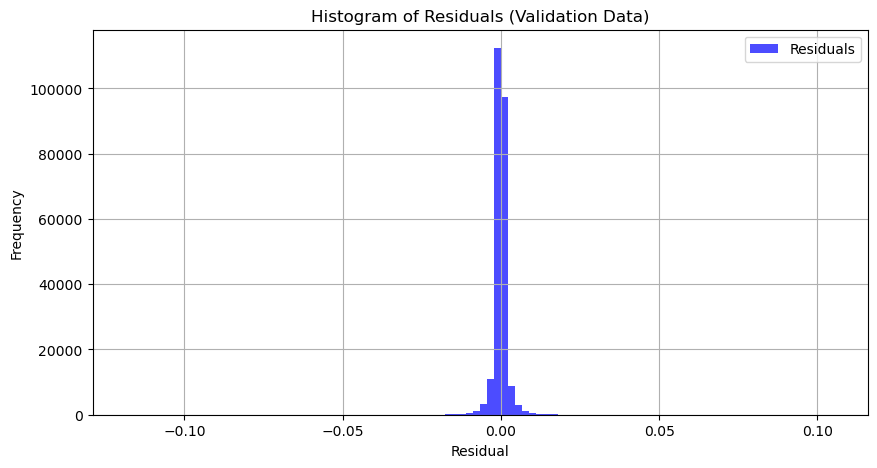

In [28]:
X_val_C = X_shuf_val[:, :C]
y_pred_val = v_best_linear_model.T @ X_val_C.T
residuals = y_shuf_val - y_pred_val

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=100, color='blue', alpha=0.7, label="Residuals")
plt.title("Histogram of Residuals (Validation Data)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()